In [1]:
import os
import tensorflow as tf
import tensorflowvisu
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dirs = ['imgs/birds/', 'imgs/sloppyjoes/']

In [3]:
def create_dataset_tensors(dirs, lim=50):
    filenames = []
    labels = []
    for i in range(len(dirs)):
        curr_dir = dirs[i]
        class_filenames = [curr_dir + val for val in os.listdir(curr_dir)[:lim]]
        labels += [i] * len(class_filenames)
        filenames += class_filenames

    # Reads an image from a file, decodes it into a dense tensor, and resizes it
    # to a fixed shape.
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image_decoded = tf.image.decode_image(image_string)
        image_decoded.set_shape([None, None, None])
        image_resized = tf.image.resize_images(image_decoded, [240, 240])
#         image_resized = tf.image.resize_image_with_crop_or_pad(image_decoded, 250, 250)
        return image_resized, label

    # A vector of filenames.
    filenames = tf.constant(filenames)

    # `labels[i]` is the label for the image in `filenames[i].
    labels = tf.constant(labels)

    dataset = tf.contrib.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    dataset = dataset.shuffle(buffer_size=10000)
    return dataset

def show_batch(batch):
    images = batch[0]
    labels = batch[1]
    for im, label in zip(images, labels):
        plt.imshow(im.astype(np.uint8))
        print('Label: ' + str(label))
        plt.show()

In [4]:
dataset = create_dataset_tensors(dirs)
batched_dataset = dataset.batch(4)
iterator = batched_dataset.make_one_shot_iterator()
next_element = iterator.get_next()
sess = tf.InteractiveSession()

In [5]:
output = sess.run(next_element)

Label: 1


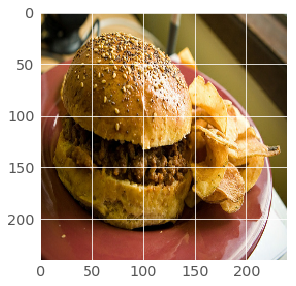

Label: 0


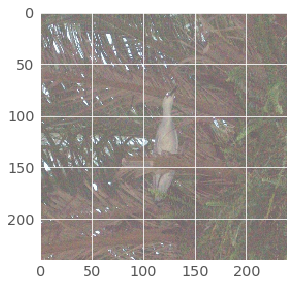

Label: 0


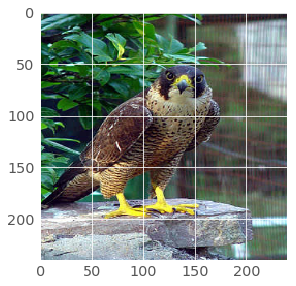

Label: 0


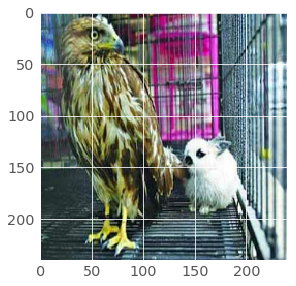

In [6]:
show_batch(output)

In [23]:
# neural network structure for this sample - IGNORE THIS SET OF COMMENTS. Totally wrong.
#
# · · · · · · · · · ·      (input data, 1-deep)                    X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer +BN 6x6x1=>24 stride 1      W1 [5, 5, 1, 24]        B1 [24]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                              Y1 [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @     -- conv. layer +BN 5x5x6=>48 stride 2      W2 [5, 5, 6, 48]        B2 [48]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                                Y2 [batch, 14, 14, 12]
#     @ @ @ @ @ @       -- conv. layer +BN 4x4x12=>64 stride 2     W3 [4, 4, 12, 64]       B3 [64]
#     ∶∶∶∶∶∶∶∶∶∶∶                                                  Y3 [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞      -- fully connected layer (relu+dropout+BN) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                                    Y4 [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)         W5 [200, 10]           B5 [10]
#        · · ·                                                     Y [batch, 10]

# input X: 240x240 color images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 240, 240, 3])
# correct answers will go here
Y_ = tf.placeholder(tf.float32, [None, 1])
# variable learning rate
lr = tf.placeholder(tf.float32)
# test flag for batch norm
tst = tf.placeholder(tf.bool)
iter = tf.placeholder(tf.int32)
# dropout probability
pkeep = tf.placeholder(tf.float32)
pkeep_conv = tf.placeholder(tf.float32)

def batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    exp_moving_avg = tf.train.ExponentialMovingAverage(0.999, iteration) # adding the iteration prevents from averaging across non-existing iterations
    bnepsilon = 1e-5
    if convolutional:
        mean, variance = tf.nn.moments(Ylogits, [0, 1, 2])
    else:
        mean, variance = tf.nn.moments(Ylogits, [0])
    update_moving_averages = exp_moving_avg.apply([mean, variance])
    m = tf.cond(is_test, lambda: exp_moving_avg.average(mean), lambda: mean)
    v = tf.cond(is_test, lambda: exp_moving_avg.average(variance), lambda: variance)
    Ybn = tf.nn.batch_normalization(Ylogits, m, v, offset, None, bnepsilon)
    return Ybn, update_moving_averages

def no_batchnorm(Ylogits, is_test, iteration, offset, convolutional=False):
    return Ylogits, tf.no_op()

def compatible_convolutional_noise_shape(Y):
    noiseshape = tf.shape(Y)
    noiseshape = noiseshape * tf.constant([1,0,0,1]) + tf.constant([0,1,1,0])
    return noiseshape

# three convolutional layers with their channel counts, and a
# fully connected layer (tha last layer has 2 softmax neurons)
K = 24  # first convolutional layer output depth
L = 48  # second convolutional layer output depth
M = 64  # third convolutional layer
N = 200  # fully connected layer

W1 = tf.Variable(tf.truncated_normal([6, 6, 3, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([60 * 60 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))
W5 = tf.Variable(tf.truncated_normal([N, 1], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [1]))

# The model
# batch norm scaling is not useful with relus
# batch norm offsets are used instead of biases
stride = 1  # output is 240x240
Y1l = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1bn, update_ema1 = batchnorm(Y1l, tst, iter, B1, convolutional=True)
Y1r = tf.nn.relu(Y1bn)
Y1 = tf.nn.dropout(Y1r, pkeep_conv, compatible_convolutional_noise_shape(Y1r))
stride = 2  # output is 120x120
Y2l = tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME')
Y2bn, update_ema2 = batchnorm(Y2l, tst, iter, B2, convolutional=True)
Y2r = tf.nn.relu(Y2bn)
Y2 = tf.nn.dropout(Y2r, pkeep_conv, compatible_convolutional_noise_shape(Y2r))
stride = 2  # output is 60x60
Y3l = tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME')
Y3bn, update_ema3 = batchnorm(Y3l, tst, iter, B3, convolutional=True)
Y3r = tf.nn.relu(Y3bn)
Y3 = tf.nn.dropout(Y3r, pkeep_conv, compatible_convolutional_noise_shape(Y3r))

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 60 * 60 * M])

Y4l = tf.matmul(YY, W4)
Y4bn, update_ema4 = batchnorm(Y4l, tst, iter, B4)
Y4r = tf.nn.relu(Y4bn)
Y4 = tf.nn.dropout(Y4r, pkeep)
Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

update_ema = tf.group(update_ema1, update_ema2, update_ema3, update_ema4)

# cross-entropy loss function (= -sum(Y_i * log(Yi)) ), normalised for batches of 100  images
# TensorFlow provides the softmax_cross_entropy_with_logits function to avoid numerical stability
# problems with log(0) which is NaN
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# matplotlib visualisation
allweights = tf.concat([tf.reshape(W1, [-1]), tf.reshape(W2, [-1]), tf.reshape(W3, [-1]), tf.reshape(W4, [-1]), tf.reshape(W5, [-1])], 0)
allbiases  = tf.concat([tf.reshape(B1, [-1]), tf.reshape(B2, [-1]), tf.reshape(B3, [-1]), tf.reshape(B4, [-1]), tf.reshape(B5, [-1])], 0)
conv_activations = tf.concat([tf.reshape(tf.reduce_max(Y1r, [0]), [-1]), tf.reshape(tf.reduce_max(Y2r, [0]), [-1]), tf.reshape(tf.reduce_max(Y3r, [0]), [-1])], 0)
dense_activations = tf.reduce_max(Y4r, [0])
# I = tensorflowvisu.tf_format_mnist_images(X, Y, Y_)
# It = tensorflowvisu.tf_format_mnist_images(X, Y, Y_, 1000, lines=25)
datavis = tensorflowvisu.MnistDataVis(title4="batch-max conv activation", title5="batch-max dense activations", histogram4colornum=2, histogram5colornum=2)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)


######
batched_dataset = dataset.batch(2)
iterator = batched_dataset.make_one_shot_iterator()
next_element = iterator.get_next()
######

# init
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [35]:
# You can call this function in a loop to train the model, 100 images at a time
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
#     batch_X, batch_Y = mnist.train.next_batch(100)
    batch_X, batch_Y = sess.run(next_element)
#     batch_Y = batch_Y.T
    batch_Y = batch_Y[np.newaxis].T
    print(batch_Y.shape)

    # learning rate decay
    max_learning_rate = 0.02
    min_learning_rate = 0.0001
    decay_speed = 1600
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)
    
    a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, tst: False, pkeep: 1.0, pkeep_conv: 1.0})

    # compute training values for visualisation
    if update_train_data:
        a, c, im, ca, da = sess.run([accuracy, cross_entropy, I, conv_activations, dense_activations], {X: batch_X, Y_: batch_Y, tst: False, pkeep: 1.0, pkeep_conv: 1.0})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(learning_rate) + ")")
        datavis.append_training_curves_data(i, a, c)
        datavis.update_image1(im)
        datavis.append_data_histograms(i, ca, da)

    # compute test values for visualisation
    if update_test_data:
        a, c, im = sess.run([accuracy, cross_entropy, It], {X: mnist.test.images, Y_: mnist.test.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        datavis.append_test_curves_data(i, a, c)
        datavis.update_image2(im)

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, tst: False, pkeep: 0.75, pkeep_conv: 1.0})
    sess.run(update_ema, {X: batch_X, Y_: batch_Y, tst: False, iter: i, pkeep: 1.0, pkeep_conv: 1.0})
    
    return a, c


# datavis.animate(training_step, 10001, train_data_update_freq=20, test_data_update_freq=100)

# to save the animation as a movie, add save_movie=True as an argument to datavis.animate
# to disable the visualisation use the following line instead of the datavis.animate line
# for i in range(10000+1): training_step(i, i % 100 == 0, i % 20 == 0)

# print("max test accuracy: " + str(datavis.get_max_test_accuracy()))

In [37]:
for j in range(1):
    print('Iteration:', j)
    a, c = training_step(j, False, False)
    print('Accuracy:', a)

Iteration: 0
(2, 1)
Accuracy: 1.0


In [26]:
sess.run(allweights)

array([ 0.09158918, -0.07409963, -0.08477493, ..., -0.02930741,
       -0.00868434, -0.14345281], dtype=float32)

In [28]:
sess.run(allweights)

array([ 0.10965306, -0.09248174, -0.06966881, ..., -0.0441901 ,
       -0.02356703, -0.15833549], dtype=float32)

In [30]:
sess.run(allweights)

array([ 0.10115719, -0.07974635, -0.05679829, ..., -0.06136486,
       -0.04074179, -0.16983981], dtype=float32)

In [33]:
 a, c, im = sess.run([accuracy, cross_entropy], {X: mnist.test.images, Y_: mnist.test.labels, tst: True, pkeep: 1.0, pkeep_conv: 1.0})

NameError: name 'mnist' is not defined